# Prepare data

## Genrate forecast

In [1]:
import torch
from torch import nn
import numpy as np
from timm.layers import trunc_normal_, DropPath
import torch.nn.functional as F
import sys
sys.path.append('..')  # 添加上一级目录到路径
from canglong.earth_position import calculate_position_bias_indices
from canglong.shift_window import create_shifted_window_mask, partition_windows, reverse_partition
from canglong.embed import ImageToPatch2D, ImageToPatch3D, ImageToPatch4D
from canglong.recovery import RecoveryImage2D, RecoveryImage3D, RecoveryImage4D
from canglong.pad import calculate_padding_3d, calculate_padding_2d
from canglong.crop import center_crop_2d, center_crop_3d
input_constant = torch.load('constant_masks/input_tensor.pt').cuda()

class UpSample(nn.Module):
    """
    Up-sampling operation.
    """

    def __init__(self, in_dim, out_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim * 4, bias=False)
        self.linear2 = nn.Linear(out_dim, out_dim, bias=False)
        self.norm = nn.LayerNorm(out_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

    def forward(self, x: torch.Tensor):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        x = self.linear1(x)
        x = x.reshape(B, in_pl, in_lat, in_lon, 2, 2, C // 2).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, in_pl, in_lat * 2, in_lon * 2, -1)

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        pad_h = in_lat * 2 - out_lat
        pad_w = in_lon * 2 - out_lon

        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top

        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        x = x[:, :out_pl, pad_top: 2 * in_lat - pad_bottom, pad_left: 2 * in_lon - pad_right, :]
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3], x.shape[4])
        x = self.norm(x)
        x = self.linear2(x)
        return x


class DownSample(nn.Module):
    """
    Down-sampling operation
    """

    def __init__(self, in_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear = nn.Linear(in_dim * 4, in_dim * 2, bias=False)
        self.norm = nn.LayerNorm(4 * in_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        h_pad = out_lat * 2 - in_lat
        w_pad = out_lon * 2 - in_lon

        pad_top = h_pad // 2
        pad_bottom = h_pad - pad_top

        pad_left = w_pad // 2
        pad_right = w_pad - pad_left

        pad_front = pad_back = 0

        self.pad = nn.ZeroPad3d(
            (pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back)
        )

    def forward(self, x):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution
        x = x.reshape(B, in_pl, in_lat, in_lon, C)

        x = self.pad(x.permute(0, -1, 1, 2, 3)).permute(0, 2, 3, 4, 1)
        x = x.reshape(B, in_pl, out_lat, 2, out_lon, 2, C).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, out_pl * out_lat * out_lon, 4 * C)

        x = self.norm(x)
        x = self.linear(x)
        return x


class EarthAttention3D(nn.Module):
    """
    3D window attention with earth position bias.
    """

    def __init__(self, dim, input_resolution, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0.,
                 proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.type_of_windows = (input_resolution[0] // window_size[0]) * (input_resolution[1] // window_size[1])

        self.earth_position_bias_table = nn.Parameter(
            torch.zeros((window_size[0] ** 2) * (window_size[1] ** 2) * (window_size[2] * 2 - 1),
                        self.type_of_windows, num_heads)
        )

        earth_position_index = calculate_position_bias_indices(window_size)
        self.register_buffer("earth_position_index", earth_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.earth_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x: torch.Tensor, mask=None):
        B_, nW_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, nW_, N, 3, self.num_heads, C // self.num_heads).permute(3, 0, 4, 1, 2, 5)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        earth_position_bias = self.earth_position_bias_table[self.earth_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1] * self.window_size[2],
            self.window_size[0] * self.window_size[1] * self.window_size[2],
            self.type_of_windows, -1
        )
        earth_position_bias = earth_position_bias.permute(
            3, 2, 0, 1).contiguous()
        attn = attn + earth_position_bias.unsqueeze(0)

        if mask is not None:
            nLon = mask.shape[0]
            attn = attn.view(B_ // nLon, nLon, self.num_heads, nW_, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, nW_, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).permute(0, 2, 3, 1, 4).reshape(B_, nW_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class EarthSpecificBlock(nn.Module):
    """
    3D Transformer Block
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=None, shift_size=None, mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        window_size = (2, 6, 12) if window_size is None else window_size
        shift_size = (1, 3, 6) if shift_size is None else shift_size
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = norm_layer(dim)
        padding = calculate_padding_3d(input_resolution, window_size)
        self.pad = nn.ZeroPad3d(padding)

        pad_resolution = list(input_resolution)
        pad_resolution[0] += (padding[-1] + padding[-2])
        pad_resolution[1] += (padding[2] + padding[3])
        pad_resolution[2] += (padding[0] + padding[1])

        self.attn = EarthAttention3D(
            dim=dim, input_resolution=pad_resolution, window_size=window_size, num_heads=num_heads, qkv_bias=qkv_bias,
            qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        shift_pl, shift_lat, shift_lon = self.shift_size
        self.roll = shift_pl and shift_lon and shift_lat

        if self.roll:
            attn_mask = create_shifted_window_mask(pad_resolution, window_size, shift_size)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x: torch.Tensor):
        Pl, Lat, Lon = self.input_resolution
        B, L, C = x.shape
        assert L == Pl * Lat * Lon, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, Pl, Lat, Lon, C)

        x = self.pad(x.permute(0, 4, 1, 2, 3)).permute(0, 2, 3, 4, 1)

        _, Pl_pad, Lat_pad, Lon_pad, _ = x.shape

        shift_pl, shift_lat, shift_lon = self.shift_size
        if self.roll:
            shifted_x = torch.roll(x, shifts=(-shift_pl, -shift_lat, -shift_lon), dims=(1, 2, 3))
            x_windows = partition_windows(shifted_x, self.window_size)
        else:
            shifted_x = x
            x_windows = partition_windows(shifted_x, self.window_size)

        win_pl, win_lat, win_lon = self.window_size
        x_windows = x_windows.view(x_windows.shape[0], x_windows.shape[1], win_pl * win_lat * win_lon, C)

        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = attn_windows.view(attn_windows.shape[0], attn_windows.shape[1], win_pl, win_lat, win_lon, C)

        if self.roll:
            shifted_x = reverse_partition(attn_windows, self.window_size, Pl_pad, Lat_pad, Lon_pad)
            x = torch.roll(shifted_x, shifts=(shift_pl, shift_lat, shift_lon), dims=(1, 2, 3))
        else:
            shifted_x = reverse_partition(attn_windows, self.window_size, Pl_pad, Lat_pad, Lon_pad)
            x = shifted_x

        x = center_crop_3d(x.permute(0, 4, 1, 2, 3), self.input_resolution).permute(0, 2, 3, 4, 1)

        x = x.reshape(B, Pl * Lat * Lon, C)
        x = shortcut + self.drop_path(x)

        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x



class BasicLayer(nn.Module):
    """A basic 3D Transformer layer for one stage"""

    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth

        self.blocks = nn.ModuleList([
            EarthSpecificBlock(dim=dim, input_resolution=input_resolution, num_heads=num_heads, window_size=window_size,
                               shift_size=(0, 0, 0) if i % 2 == 0 else None, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                               qk_scale=qk_scale, drop=drop, attn_drop=attn_drop,
                               drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                               norm_layer=norm_layer)
            for i in range(depth)
        ])

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x




class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    
import torch
import torch.nn as nn
from canglong.helper import ResidualBlock, NonLocalBlock, DownSampleBlock, UpSampleBlock, GroupNorm, Swish

class Encoder(nn.Module):
    def __init__(self, image_channels, latent_dim):
        super(Encoder, self).__init__()
        channels = [64, 64, 64, 128, 128]
        attn_resolutions = [2]
        num_res_blocks = 1
        resolution = 256

        # 初始卷积层
        self.conv_in = nn.Conv3d(image_channels, channels[0], kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        
        # 第一层（含残差块和注意力模块）
        self.layer1 = self._make_layer(channels[0], channels[1], num_res_blocks, resolution, attn_resolutions)
        
        # 下采样与第二层
        self.downsample1 = DownSampleBlock(channels[1])
        self.layer2 = self._make_layer(channels[1], channels[2], num_res_blocks, resolution // 2, attn_resolutions)

        # Further downsampling and third layer
        self.downsample2 = DownSampleBlock(channels[2])
        self.layer3 = self._make_layer(channels[2], channels[3], num_res_blocks, resolution // 4, attn_resolutions)

        # 中间层的残差块和注意力模块
        self.mid_block1 = ResidualBlock(channels[3], channels[3])
        self.mid_block2 = ResidualBlock(channels[3], channels[3])
        
        # 输出层的归一化、激活和最终卷积层
        self.norm_out = GroupNorm(channels[3])
        self.act_out = Swish()
        self.conv_out = nn.Conv3d(channels[3], latent_dim, kernel_size=3, stride=1, padding=(1,2,1))

    def _make_layer(self, in_channels, out_channels, num_res_blocks, resolution, attn_resolutions):
        layers = []
        for _ in range(num_res_blocks):
            layers.append(ResidualBlock(in_channels, out_channels))
            in_channels = out_channels
            if resolution in attn_resolutions:
                layers.append(NonLocalBlock(in_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 初始卷积
        x = self.conv_in(x)

        # 第一层，并存储跳跃连接
        x = self.layer1(x)
        skip = x  # 保存第一层输出，用于后续跳跃连接

        # 下采样，进入第二层
        x = self.downsample1(x)
        x = self.layer2(x)

        # Further downsample and third layer
        x = self.downsample2(x)
        x = self.layer3(x)

        # 中间层的残差块和注意力模块
        x = self.mid_block1(x)
        #x = self.mid_attn(x)
        x = self.mid_block2(x)
        
        # 最终的归一化、激活和卷积输出层
        x = self.norm_out(x)
        x = self.act_out(x)
        x = self.conv_out(x)[:, :, :, :181, :360]
        
        return x
    
class Decoder(nn.Module):
    def __init__(self, image_channels=14, latent_dim=64):
        super(Decoder, self).__init__()
        channels = [128, 128, 64, 64]  # Decoder 的通道配置
        num_res_blocks = 1  # 与 Encoder 对齐

        # 初始卷积层
        self.conv_in = nn.Conv3d(latent_dim, channels[0], kernel_size=3, stride=1, padding=1)
        
        # 第一层残差块
        self.layer1 = self._make_layer(channels[0], channels[1], num_res_blocks)
        
        # 上采样和第二层残差块
        self.upsample1 = UpSampleBlock(channels[1])
        self.layer2 = self._make_layer(channels[1], channels[2], num_res_blocks)

        self.upsample2 = UpSampleBlock(channels[2])
        self.layer3 = self._make_layer(channels[2], channels[3], num_res_blocks)
        
        # 中间层的残差块
        self.mid_block1 = ResidualBlock(channels[3], channels[3])
        self.mid_block2 = ResidualBlock(channels[3], channels[3])
        
        # 最终输出层
        self.norm_out = GroupNorm(channels[3])
        self.act_out = Swish()
        self.conv_out = nn.ConvTranspose3d(channels[3], image_channels, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))

    def _make_layer(self, in_channels, out_channels, num_res_blocks):
        # 创建指定数量的残差块
        layers = [ResidualBlock(in_channels, out_channels) for _ in range(num_res_blocks)]
        return nn.Sequential(*layers)

    def forward(self, x):
        # 初始卷积
        x = self.conv_in(x)

        # 第一层残差块
        x = self.layer1(x)

        # 上采样和第二层残差块
        x = self.upsample1(x)  # 上采样后通道数保持不变

        x = self.layer2(x)     # 确保输入与 layer2 的期望通道数匹配

        x = self.upsample2(x)  # 上采样后通道数保持不变

        x = self.layer3(x)     # 确保输入与 layer2 的期望通道数匹配
        
        # 中间层的残差块
        x = self.mid_block1(x)
        x = self.mid_block2(x)
        
        # 最终的归一化、激活和卷积输出层
        x = self.norm_out(x)
        x = self.act_out(x)

        x = self.conv_out(x)[:, :, :, :721, :1440]
        
        return x


class Canglong(nn.Module):
    """
    CAS Canglong PyTorch impl of: `CAS-Canglong: A skillful 3D Transformer model for sub-seasonal to seasonal global sea surface temperature prediction`
    """

    def __init__(self, embed_dim=96, num_heads=(8, 16, 16, 8), window_size=(2, 6, 12)):
        super().__init__()
        drop_path = np.linspace(0, 0.2, 8).tolist()
        self.patchembed2d = ImageToPatch2D(
            img_dims=(721, 1440),
            patch_dims=(4, 4), # 8, 8
            in_channels=4,
            out_channels=embed_dim,
        )
        self.patchembed3d = ImageToPatch3D(
            img_dims=(14, 721, 1440),
            patch_dims=(1, 4, 4),
            in_channels=14,
            out_channels=embed_dim
        )
        self.patchembed4d = ImageToPatch4D(
            img_dims=(7, 4, 721, 1440),
            patch_dims=(4, 2, 4, 4),
            in_channels=7,
            out_channels=embed_dim
        )
        self.encoder3d = Encoder(image_channels=16, latent_dim=96)

        self.layer1 = BasicLayer(
            dim=embed_dim,
            input_resolution=(4, 181, 360),
            depth=2,
            num_heads=num_heads[0],
            window_size=window_size,
            drop_path=drop_path[:2]
        )
        self.downsample = DownSample(in_dim=embed_dim, input_resolution=(4, 181, 360), output_resolution=(4, 91, 180))
        self.layer2 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(4, 91, 180),
            depth=6,
            num_heads=num_heads[1],
            window_size=window_size,
            drop_path=drop_path[2:]
        )
        self.layer3 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(4, 91, 180),
            depth=6,
            num_heads=num_heads[2],
            window_size=window_size,
            drop_path=drop_path[2:]
        )
        self.upsample = UpSample(embed_dim * 2, embed_dim, (4, 91, 180), (4, 181, 360))
        self.layer4 = BasicLayer(
            dim=embed_dim,
            input_resolution=(4, 181, 360),
            depth=2,
            num_heads=num_heads[3],
            window_size=window_size,
            drop_path=drop_path[:2]
        )
        self.patchrecovery2d = RecoveryImage2D((721, 1440), (4, 4), 2 * embed_dim, 4) #8, 8
        self.decoder3d = Decoder(image_channels=16, latent_dim=2 * 96)
        self.patchrecovery3d = RecoveryImage3D(image_size=(16, 721, 1440), 
                                               patch_size=(1, 4, 4), 
                                               input_channels=2 * embed_dim, 
                                               output_channels=16) #2, 8, 8
        self.patchrecovery4d = RecoveryImage4D(image_size=(7, 4, 721, 1440), 
                                               patch_size=(4, 2, 4, 4), 
                                               input_channels=2 * embed_dim, 
                                               output_channels=7)
        self.conv_constant = nn.Conv2d(in_channels=4, out_channels=96, kernel_size=5, stride=4, padding=2)
        self.input_constant = input_constant


    def forward(self, surface, upper_air):
        
        
        constant = self.conv_constant(self.input_constant)
        surface = self.encoder3d(surface)

        upper_air = self.patchembed4d(upper_air)
        

        x = torch.concat([upper_air.squeeze(3), constant.unsqueeze(2), surface], dim=2)

        B, C, Pl, Lat, Lon = x.shape

        x = x.reshape(B, C, -1).transpose(1, 2)
        
        x = self.layer1(x)

        skip = x

        x = self.downsample(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.upsample(x)
        x = self.layer4(x)

        output = torch.concat([x, skip], dim=-1)
        output = output.transpose(1, 2).reshape(B, -1, Pl, Lat, Lon)

        output_surface = output[:, :, 2:, :, :]
        output_upper_air = output[:, :, 0, :, :]

        #output_surface = self.patchrecovery3d(output_surface)
        output_surface = self.decoder3d(output_surface)

        output_upper_air = self.patchrecovery4d(output_upper_air.unsqueeze(2).unsqueeze(3))

        return output_surface, output_upper_air


In [6]:
normalized_input_surface = torch.load('/data/lhwang/npy/input_surface_norm_test_last100.pt')
normalized_input_upper_air = torch.load('/data/lhwang/npy/input_upper_air_norm_test_last100.pt')
print(normalized_input_surface.shape, normalized_input_upper_air.shape)


torch.Size([16, 100, 721, 1440]) torch.Size([7, 4, 100, 721, 1440])


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import tqdm

class WeatherDataset(Dataset):
    def __init__(self, surface_data, upper_air_data, start_idx, end_idx):
        """
        初始化气象数据集 - 按时间序列顺序划分
        
        参数:
            surface_data: 表面数据，形状为 [16, 100, 721, 1440]
            upper_air_data: 高空数据，形状为 [7, 4, 100, 721, 1440]
            start_idx: 开始索引
            end_idx: 结束索引
        """
        self.surface_data = surface_data[:, start_idx:end_idx]
        self.upper_air_data = upper_air_data[:, :, start_idx:end_idx]
        self.length = end_idx - start_idx - 2  # 减2确保有足够的目标数据
        
        print(f"Dataset from index {start_idx} to {end_idx}, sample count: {self.length}")
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        # 提取输入数据 (t和t+1时刻)
        input_surface = self.surface_data[:, idx:idx+2]  # [1, 16, 2, 721, 1440]
        
        # 提取高空数据 (t和t+1时刻)
        input_upper_air = self.upper_air_data[:, :, idx:idx+2]  # [1, 7, 4, 2, 721, 1440]
        
        # 提取目标数据 (t+2时刻)
        target_surface = self.surface_data[:, idx:idx+2]  # [1, 16, 721, 1440]
        target_upper_air = self.upper_air_data[:, :, idx:idx+2]  # [1, 7, 4, 721, 1440]
        
        return input_surface, input_upper_air, target_surface, target_upper_air
    
# 设置设备
device = torch.device('cuda:1')

# 创建数据集
dataset = WeatherDataset(
    surface_data=normalized_input_surface,
    upper_air_data=normalized_input_upper_air,
    start_idx=0,
    end_idx=100  # 使用全部100个时间步
)

# 创建数据加载器
batch_size = 1  # 由于数据较大，建议使用batch_size=1
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,  # 推理时不需要打乱数据
    num_workers=4,  # 根据CPU核心数调整
    pin_memory=True  # 使用固定内存加速数据传输到GPU
)

# 将数据移动到CUDA 1
normalized_input_surface = normalized_input_surface.to(device)
input_upper_air = normalized_input_upper_air.to(device)


Dataset from index 0 to 100, sample count: 98


In [ ]:
# 设置设备
device = torch.device('cuda:1')

# 加载模型
model_path = '/home/lhwang/Desktop/model/model_epoch_500.pt'
print(f"正在从 {model_path} 加载模型...")
model = torch.load(model_path, weights_only=False)
model = model.module
model.to(device)
model.eval()
print("模型加载成功")

# 设置预测参数
forecast_weeks = 1  # 单次预测一周
batch_size = 1

# 创建数据加载器
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# 存储所有预测结果
all_surface_predictions = []
all_upper_air_predictions = []

print("开始批量预测...")

# 推理循环
with torch.no_grad():
    for batch_idx, (input_surface, input_upper_air, target_surface, target_upper_air) in enumerate(dataloader):
        # 将数据移动到GPU
        input_surface = input_surface.to(device)
        input_upper_air = input_upper_air.to(device)
        
        # 前向传播
        output_surface, output_upper_air = model(input_surface, input_upper_air)
        
        # 存储预测结果
        all_surface_predictions.append(output_surface.cpu())
        all_upper_air_predictions.append(output_upper_air.cpu())
        
        # 打印进度
        if batch_idx % 10 == 0:
            print(f"处理批次 {batch_idx}/{len(dataloader)}")
            print(f"输入形状: {input_surface.shape}, {input_upper_air.shape}")
            print(f"输出形状: {output_surface.shape}, {output_upper_air.shape}")

# 合并所有预测结果
all_surface_predictions = torch.cat(all_surface_predictions, dim=0)  # [batch_size, 16, 1, 721, 1440]
all_upper_air_predictions = torch.cat(all_upper_air_predictions, dim=0)  # [batch_size, 7, 4, 1, 721, 1440]

print(f"预测完成。")
print(f"地表预测形状: {all_surface_predictions.shape}")
print(f"高空预测形状: {all_upper_air_predictions.shape}")

# 将预测结果转换为numpy数组
surface_predictions_np = all_surface_predictions.numpy()
upper_air_predictions_np = all_upper_air_predictions.numpy()

正在从 /home/lhwang/Desktop/model/model_epoch_500.pt 加载模型...
模型加载成功
开始批量预测...
处理批次 0/98
输入形状: torch.Size([1, 16, 2, 721, 1440]), torch.Size([1, 7, 4, 2, 721, 1440])
输出形状: torch.Size([1, 16, 2, 721, 1440]), torch.Size([1, 7, 4, 2, 721, 1440])
处理批次 10/98
输入形状: torch.Size([1, 16, 2, 721, 1440]), torch.Size([1, 7, 4, 2, 721, 1440])
输出形状: torch.Size([1, 16, 2, 721, 1440]), torch.Size([1, 7, 4, 2, 721, 1440])
处理批次 20/98
输入形状: torch.Size([1, 16, 2, 721, 1440]), torch.Size([1, 7, 4, 2, 721, 1440])
输出形状: torch.Size([1, 16, 2, 721, 1440]), torch.Size([1, 7, 4, 2, 721, 1440])
处理批次 30/98
输入形状: torch.Size([1, 16, 2, 721, 1440]), torch.Size([1, 7, 4, 2, 721, 1440])
输出形状: torch.Size([1, 16, 2, 721, 1440]), torch.Size([1, 7, 4, 2, 721, 1440])
处理批次 40/98
输入形状: torch.Size([1, 16, 2, 721, 1440]), torch.Size([1, 7, 4, 2, 721, 1440])
输出形状: torch.Size([1, 16, 2, 721, 1440]), torch.Size([1, 7, 4, 2, 721, 1440])
处理批次 50/98
输入形状: torch.Size([1, 16, 2, 721, 1440]), torch.Size([1, 7, 4, 2, 721, 1440])
输出形状: torch.S

In [10]:
surface_predictions_np.shape

(98, 16, 2, 721, 1440)

In [162]:
# 变量统计信息
# 变量列表及其统计信息

variables = [
    'lsrr',               # Large-scale precipitation rate
    'crr',                # Convective precipitation rate
    'tciw',               # Specific cloud ice
    'tcc',                # Total cloud cover
    'tsrc',               # Top net long-wave radiation flux
    'u10',                # 10m u wind component
    'v10',                # 10m v wind component
    'd2m',                # 2m dewpoint temperature
    't2m',                # 2m temperature
    'surface_latent_heat_flux',  # Surface latent heat flux
    'surface_sensible_heat_flux',  # Surface sensible heat flux
    'sp',                 # Surface pressure
    'swvl',               # Volumetric soil water
    'msl',                # Sea-level pressure
    'siconc',             # Sea ice
    'sst'                 # Sea surface temperature
]

ordered_var_stats = {
    'lsrr': {'mean': 1.10E-05, 'std': 2.55E-05},
    'crr': {'mean': 1.29E-05, 'std': 2.97E-05},
    'tciw': {'mean': 0.022627383, 'std': 0.023428712},
    'tcc': {'mean': 0.673692584, 'std': 0.235167906},
    'tsrc': {'mean': 856148, 'std': 534222.125},
    'u10': {'mean': -0.068418466, 'std': 4.427545547},
    'v10': {'mean': 0.197138891, 'std': 3.09530735},
    'd2m': {'mean': 274.2094421, 'std': 20.45770073},
    't2m': {'mean': 278.7841187, 'std': 21.03286934},
    'surface_latent_heat_flux': {'mean': -5410301.5, 'std': 5349063.5},
    'surface_sensible_heat_flux': {'mean': -971651.375, 'std': 2276764.75},
    'sp': {'mean': 96651.14063, 'std': 9569.695313},
    'swvl': {'mean': 0.34216917, 'std': 0.5484813},
    'msl': {'mean': 100972.3438, 'std': 1191.102417},
    'siconc': {'mean': 0.785884917, 'std': 0.914535105},
    'sst': {'mean': 189.7337189, 'std': 136.1803131},
    
    # 高空层变量（按新顺序排列）
    'geopotential': {
        '300': {'mean': 13763.50879, 'std': 1403.990112},
        '500': {'mean': 28954.94531, 'std': 2085.838867},
        '700': {'mean': 54156.85547, 'std': 3300.384277},
        '850': {'mean': 89503.79688, 'std': 5027.79541}
    },
    'vertical_velocity': {
        '300': {'mean': 0.011849277, 'std': 0.126232564},
        '500': {'mean': 0.002759292, 'std': 0.097579598},
        '700': {'mean': 0.000348145, 'std': 0.072489716},
        '850': {'mean': 0.000108061, 'std': 0.049831692}
    },
    'u_component_of_wind': {
        '300': {'mean': 1.374536991, 'std': 6.700420856},
        '500': {'mean': 3.290786982, 'std': 7.666454315},
        '700': {'mean': 6.491596222, 'std': 9.875613213},
        '850': {'mean': 11.66026878, 'std': 14.00845909}
    },
    'v_component_of_wind': {
        '300': {'mean': 0.146550566, 'std': 3.75399971},
        '500': {'mean': 0.022800878, 'std': 4.179731846},
        '700': {'mean': -0.025720235, 'std': 5.324173927},
        '850': {'mean': -0.027837994, 'std': 7.523460865}
    },
    'fraction_of_cloud_cover': {
        '300': {'mean': 0.152513072, 'std': 0.15887706},
        '500': {'mean': 0.106524825, 'std': 0.144112185},
        '700': {'mean': 0.105878539, 'std': 0.112193666},
        '850': {'mean': 0.108120449, 'std': 0.108371623}
    },
    'temperature': {
        '300': {'mean': 274.8048401, 'std': 15.28209305},
        '500': {'mean': 267.6254578, 'std': 14.55300999},
        '700': {'mean': 253.1627655, 'std': 12.77071381},
        '850': {'mean': 229.0860138, 'std': 10.5536499}
    },
    'specific_humidity': {
        '300': {'mean': 0.004610791, 'std': 0.003879665},
        '500': {'mean': 0.002473272, 'std': 0.002312181},
        '700': {'mean': 0.000875093, 'std': 0.000944978},
        '850': {'mean': 0.000130984, 'std': 0.000145811}
    }
}

In [12]:
# 准备地表数据的均值和标准差数组，形状为(16,1,1,1)
surface_means = np.array([ordered_var_stats[var]['mean'] for var in variables])
surface_stds = np.array([ordered_var_stats[var]['std'] for var in variables])

# 重塑形状用于广播
surface_means = surface_means.reshape(-1, 1, 1, 1)
surface_stds = surface_stds.reshape(-1, 1, 1, 1)

# 一次性反标准化所有地表数据
denormalized_surface = surface_predictions_np * surface_stds + surface_means

print(f"反标准化后的地表数据形状: {denormalized_surface.shape}")

反标准化后的地表数据形状: (98, 16, 2, 721, 1440)


In [13]:
# 提取并转换变量
# 1. 降水 (large_scale_rain_rate + convective_rain_rate) 转换为 mm/day
precipitation = (denormalized_surface[:, 0] + denormalized_surface[:, 1]) * 24.0 * 1000.0  # [98, 2, 721, 1440]

# 2. 风速 (sqrt(u10^2 + v10^2))
wind_speed = np.sqrt(denormalized_surface[:, 5]**2 + denormalized_surface[:, 6]**2)  # [98, 2, 721, 1440]

# 3. 露点温度 (从开尔文转换为摄氏度)
dewpoint = denormalized_surface[:, 7] - 273.15  # [98, 2, 721, 1440]

# 4. 温度 (从开尔文转换为摄氏度)
temperature = denormalized_surface[:, 8] - 273.15  # [98, 2, 721, 1440]

# 合并所有变量，顺序为：降水、风速、露点温度、温度
extracted_vars = np.stack([precipitation, wind_speed, dewpoint, temperature], axis=1)  # [98, 4, 2, 721, 1440]

print(f"提取后的变量形状: {extracted_vars.shape}")
print("变量顺序: 降水(mm/day), 风速(m/s), 露点温度(°C), 温度(°C)")

提取后的变量形状: (98, 4, 2, 721, 1440)
变量顺序: 降水(mm/day), 风速(m/s), 露点温度(°C), 温度(°C)


In [15]:
# 只提取当前时刻的预测（第一个时间点）
current_predictions = extracted_vars[:, :, 0, :, :]  # [98, 4, 721, 1440]
print(f"当前时刻预测的形状: {current_predictions.shape}")
np.save('/home/lhwang/Desktop/data/PWDT_last100.npy', current_predictions)

当前时刻预测的形状: (98, 4, 721, 1440)


## Generate real

In [163]:
normalized_input_surface = torch.load('/data/lhwang/npy/input_surface_norm_test_last100.pt')
normalized_input_upper_air = torch.load('/data/lhwang/npy/input_upper_air_norm_test_last100.pt')
print(normalized_input_surface.shape, normalized_input_upper_air.shape)


torch.Size([16, 100, 721, 1440]) torch.Size([7, 4, 100, 721, 1440])


In [166]:
normalized_input_surface1= normalized_input_surface.permute(1, 0, 2, 3).unsqueeze(2)

In [167]:
# 准备地表数据的均值和标准差数组，形状为(16,1,1,1)
surface_means = np.array([ordered_var_stats[var]['mean'] for var in variables])
surface_stds = np.array([ordered_var_stats[var]['std'] for var in variables])

# 重塑形状用于广播
surface_means = surface_means.reshape(-1, 1, 1, 1)
surface_stds = surface_stds.reshape(-1, 1, 1, 1)

# 一次性反标准化所有地表数据
denormalized_surface = normalized_input_surface1 * surface_stds + surface_means

print(f"反标准化后的地表数据形状: {denormalized_surface.shape}")

反标准化后的地表数据形状: torch.Size([100, 16, 1, 721, 1440])


In [174]:
# 提取并转换变量
# 1. 降水 (large_scale_rain_rate + convective_rain_rate) 转换为 mm/day
precipitation = (denormalized_surface[:, 0] + denormalized_surface[:, 1]) * 24.0 * 1000.0  # [98, 2, 721, 1440]

# 2. 风速 (sqrt(u10^2 + v10^2))
wind_speed = np.sqrt(denormalized_surface[:, 5]**2 + denormalized_surface[:, 6]**2)  # [98, 2, 721, 1440]

# 3. 露点温度 (从开尔文转换为摄氏度)
dewpoint = denormalized_surface[:, 7] - 273.15  # [98, 2, 721, 1440]

# 4. 温度 (从开尔文转换为摄氏度)
temperature = denormalized_surface[:, 8] - 273.15  # [98, 2, 721, 1440]

# 合并所有变量，顺序为：降水、风速、露点温度、温度
extracted_vars = np.stack([precipitation, wind_speed, dewpoint, temperature], axis=1)  # [98, 4, 2, 721, 1440]

print(f"提取后的变量形状: {extracted_vars.shape}")
print("变量顺序: 降水(mm/day), 风速(m/s), 露点温度(°C), 温度(°C)")

提取后的变量形状: (100, 4, 1, 721, 1440)
变量顺序: 降水(mm/day), 风速(m/s), 露点温度(°C), 温度(°C)


In [175]:
# 只提取当前时刻的预测（第一个时间点）
current_predictions = extracted_vars[:, :, 0, :, :]  # [98, 4, 721, 1440]
print(f"当前时刻预测的形状: {current_predictions.shape}")
np.save('/home/lhwang/Desktop/data/PWDT_last100_obs.npy', current_predictions)

当前时刻预测的形状: (100, 4, 721, 1440)


## Weather station

In [132]:
import os
import numpy as np
import pandas as pd

# 定义数据路径
data_path_start = '/home/lhwang/Desktop/data/NOAA/2022'
data_path_end = '/home/lhwang/Desktop/data/NOAA/2023'

# 获取两个年份的站点文件列表
stations_start = set(os.listdir(data_path_start))
stations_end = set(os.listdir(data_path_end))

# 找出共有站点
common_stations = sorted(list(stations_start.intersection(stations_end)))
print(f"初始共有站点数量: {len(common_stations)}")

# 创建存储站点坐标的列表
station_coords = []
valid_stations = []

# 遍历共有站点，提取经纬度信息
for station in common_stations:
    # 读取2023年的数据文件
    file_path = os.path.join(data_path_start, station)
    try:
        # 读取文件的第一行来获取经纬度
        df = pd.read_csv(file_path, nrows=1)
        
        # 提取经纬度
        lon = df['LONGITUDE'].values[0]  # 经度
        lat = df['LATITUDE'].values[0]   # 纬度
        
        # 检查经纬度是否有效（不是NaN或0）
        if not (np.isnan(lon) or np.isnan(lat) or lon == 0 or lat == 0):
            station_coords.append([lon, lat])
            valid_stations.append(station)
        else:
            print(f"站点 {station} 的经纬度无效: 经度={lon}, 纬度={lat}")
            
    except Exception as e:
        print(f"处理站点 {station} 时出错: {e}")

# 转换为numpy数组
station_coords = np.array(station_coords)
common_stations = valid_stations

# 按站点名称排序
sorted_indices = np.argsort(common_stations)
station_coords = station_coords[sorted_indices]
common_stations = [common_stations[i] for i in sorted_indices]

# 保存结果
print(f"\n有效站点数量: {len(common_stations)}")
print(f"站点坐标矩阵形状: {station_coords.shape}")
print("\n前5个站点的坐标:")
for i in range(min(5, len(common_stations))):
    print(f"站点: {common_stations[i]}, 经度: {station_coords[i,0]:.2f}, 纬度: {station_coords[i,1]:.2f}")

# 保存有效站点信息
np.save('/home/lhwang/Desktop/data/station_coords_2022_2023.npy', station_coords)
with open('/home/lhwang/Desktop/data/common_stations_names_2022_2023.txt', 'w') as f:
    for station in common_stations:
        f.write(f"{station}\n")

# 打印一些统计信息
print("\n经纬度范围:")
print(f"经度范围: {station_coords[:,0].min():.2f} 到 {station_coords[:,0].max():.2f}")
print(f"纬度范围: {station_coords[:,1].min():.2f} 到 {station_coords[:,1].max():.2f}")

初始共有站点数量: 12050
站点 65473099999.csv 的经纬度无效: 经度=0.0, 纬度=5.6166667
站点 89009090001.csv 的经纬度无效: 经度=0.0, 纬度=-90.0
站点 99999900126.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900157.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900170.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900177.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900179.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900180.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900210.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900234.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900236.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900237.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900238.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900263.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900288.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900319.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900321.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900322.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900325.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900335.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900349.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900378.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 99999900379.csv 的经纬度无效: 经度=nan, 纬度=nan
站点 9999990

In [133]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def get_week_ranges(year):
    """获取指定年份的周范围"""
    weeks = []
    start_date = datetime(year, 1, 1)
    
    for week in range(52):
        week_start = start_date + timedelta(days=week*7)
        week_end = week_start + timedelta(days=6)
        weeks.append((week_start, week_end))
    
    return weeks

def process_station_data(file_path, week_ranges):
    """处理单个站点的数据，计算周平均值"""
    # 读取站点数据
    df = pd.read_csv(file_path)
    
    # 确保时间列是datetime格式
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    # 初始化周平均值数组
    weekly_means = np.zeros((len(week_ranges), 4)) * np.nan
    
    # 处理缺失值
    # 温度相关变量 (9999.9)
    df['TEMP'] = df['TEMP'].replace(9999.9, np.nan)
    df['DEWP'] = df['DEWP'].replace(9999.9, np.nan)
    
    # 风速 (999.9)
    df['WDSP'] = df['WDSP'].replace(999.9, np.nan)
    
    # 降水 (99.99)
    df['PRCP'] = df['PRCP'].replace(99.99, np.nan)
    
    # 计算每周的平均值
    for i, (week_start, week_end) in enumerate(week_ranges):
        # 获取当前周的数据
        week_data = df[(df['DATE'] >= week_start) & (df['DATE'] <= week_end)]
        
        if not week_data.empty:
            # 计算各变量的周平均值
            # 降水 (PRCP) - 转换为 mm/day
            prcp = week_data['PRCP'].values
            weekly_means[i, 0] = np.nanmean(prcp) * 25.4 * 24.0  # 英寸转mm/day
            
            # 风速 (WDSP) - 转换为 m/s
            wdsp = week_data['WDSP'].values
            weekly_means[i, 1] = np.nanmean(wdsp) * 0.514444  # 节转m/s
            
            # 露点温度 (DEWP) - 转换为摄氏度
            dewp = week_data['DEWP'].values
            weekly_means[i, 2] = (np.nanmean(dewp) - 32) * 5/9  # 华氏度转摄氏度
            
            # 温度 (TEMP) - 转换为摄氏度
            temp = week_data['TEMP'].values
            weekly_means[i, 3] = (np.nanmean(temp) - 32) * 5/9  # 华氏度转摄氏度
    
    return weekly_means

# 主处理流程
def process_all_stations():
    # 获取共有站点列表和坐标
    common_stations = np.loadtxt('/home/lhwang/Desktop/data/common_stations_names_2022_2023.txt', dtype=str)
    station_coords = np.load('/home/lhwang/Desktop/data/station_coords_2022_2023.npy')
    
    # 初始化结果数组
    years = [2022, 2023]
    total_weeks = 52 * len(years)
    station_num = len(common_stations)
    result = np.zeros((total_weeks, station_num, 4)) * np.nan
    
    # 处理每个年份的数据
    for year_idx, year in enumerate(years):
        data_path = f'/home/lhwang/Desktop/data/NOAA/{year}'
        week_ranges = get_week_ranges(year)
        
        # 处理每个站点
        for station_idx, station in enumerate(common_stations):

            file_path = os.path.join(data_path, station)
            try:
                # 处理单个站点的数据
                weekly_means = process_station_data(file_path, week_ranges)
                
                # 将结果存入总数组
                start_idx = year_idx * 52
                end_idx = (year_idx + 1) * 52
                result[start_idx:end_idx, station_idx, :] = weekly_means
                
            except Exception as e:
                print(f"处理站点 {station} 在 {year} 年时出错: {e}")
    
    return result

# 执行处理
print("开始处理站点数据...")
weekly_station_data = process_all_stations()
print(f"处理完成。数据形状: {weekly_station_data.shape}")

# 保存结果
#np.save('weekly_station_data.npy', weekly_station_data)

# 打印一些统计信息
print("\n数据统计信息:")
print("每个变量的非NaN值数量:")
print(np.sum(~np.isnan(weekly_station_data), axis=(0,1)))
print("\n每个变量的平均值:")
print(np.nanmean(weekly_station_data, axis=(0,1)))
print("\n每个变量的标准差:")
print(np.nanstd(weekly_station_data, axis=(0,1)))

开始处理站点数据...


/tmp/ipykernel_2451606/1612400505.py:49: RuntimeWarning: Mean of empty slice
  weekly_means[i, 0] = np.nanmean(prcp) * 25.4 * 24.0  # 英寸转mm/day
/tmp/ipykernel_2451606/1612400505.py:49: RuntimeWarning: Mean of empty slice
  weekly_means[i, 0] = np.nanmean(prcp) * 25.4 * 24.0  # 英寸转mm/day
/tmp/ipykernel_2451606/1612400505.py:53: RuntimeWarning: Mean of empty slice
  weekly_means[i, 1] = np.nanmean(wdsp) * 0.514444  # 节转m/s
/tmp/ipykernel_2451606/1612400505.py:49: RuntimeWarning: Mean of empty slice
  weekly_means[i, 0] = np.nanmean(prcp) * 25.4 * 24.0  # 英寸转mm/day
/tmp/ipykernel_2451606/1612400505.py:57: RuntimeWarning: Mean of empty slice
  weekly_means[i, 2] = (np.nanmean(dewp) - 32) * 5/9  # 华氏度转摄氏度
/tmp/ipykernel_2451606/1612400505.py:49: RuntimeWarning: Mean of empty slice
  weekly_means[i, 0] = np.nanmean(prcp) * 25.4 * 24.0  # 英寸转mm/day
/tmp/ipykernel_2451606/1612400505.py:53: RuntimeWarning: Mean of empty slice
  weekly_means[i, 1] = np.nanmean(wdsp) * 0.514444  # 节转m/s
/tmp/ipyk

处理完成。数据形状: (104, 12010, 4)

数据统计信息:
每个变量的非NaN值数量:
[1156387 1129509 1117753 1168377]

每个变量的平均值:
[41.51514428  3.18593772  7.02824845 13.43046552]

每个变量的标准差:
[98.41919132  1.87750832 11.73449712 12.49482905]


In [134]:
np.save('/home/lhwang/Desktop/data/weekly_station_data_2022_2023.npy', weekly_station_data)

In [135]:
weekly_station_data.shape

(104, 12010, 4)

## DEM

In [136]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

def extract_orographic_info_corrected(station_coords):
    """
    修正版地形信息提取 - 处理0-360度栅格数据与-180到180度站点坐标的匹配
    参考文档中处理网格化卫星数据的方法[[6]](https://poe.com/citation?message_id=397216255020&citation=6)
    """
    height, width = 721, 1440
    
    # 原始栅格数据是0-360度格式，需要重新排列为-180到180度
    print("正在处理坐标系统转换...")
    
    # 加载原始数据（0-360度格式）
    land_cover = np.load('constant_masks/land_cover.npy')
    soil_type = np.load('constant_masks/soil_type.npy')
    topography = np.load('constant_masks/topography.npy')
    
    print(f"原始数据形状: {land_cover.shape}")
    
    
    # 定义重排后的经纬度网格（-180到180度）
    lon_grid = np.linspace(-179.875, 179.875, width)
    lat_grid = np.linspace(-89.875, 89.875, height)
    
    print(f"网格定义: 经度{lon_grid[0]:.3f}到{lon_grid[-1]:.3f}, 纬度{lat_grid[0]:.3f}到{lat_grid[-1]:.3f}")
    
    # 使用重排后的数据创建插值器
    land_cover_interp = RegularGridInterpolator(
        (lat_grid, lon_grid), land_cover, method='nearest', 
        bounds_error=False, fill_value=0)
    
    soil_type_interp = RegularGridInterpolator(
        (lat_grid, lon_grid), soil_type, method='nearest', 
        bounds_error=False, fill_value=0)
    
    topography_interp = RegularGridInterpolator(
        (lat_grid, lon_grid), topography, method='nearest', 
        bounds_error=False, fill_value=0)
    
    # 处理站点坐标（已经是-180到180度格式）
    station_lons = station_coords[:, 0] + 180  # -180到180度
    station_lats = -station_coords[:, 1]  # -90到90度
    
    # 确保坐标在有效范围内
    station_lons = np.clip(station_lons, -179.875, 179.875)
    station_lats = np.clip(station_lats, -89.875, 89.875)
    
    interp_points = np.column_stack([station_lats, station_lons])
    
    print(f"站点坐标范围: 经度{station_lons.min():.3f}到{station_lons.max():.3f}, 纬度{station_lats.min():.3f}到{station_lats.max():.3f}")
    
    # 插值提取
    land_cover_values = land_cover_interp(interp_points)
    soil_type_values = soil_type_interp(interp_points)
    topography_values = topography_interp(interp_points)
    
    orographic_info = np.column_stack([
        land_cover_values, soil_type_values, topography_values
    ]).astype(np.float32)
    
    print(f"成功提取地形信息: {orographic_info.shape}")
    
    # 验证第一个点的提取结果
    if len(station_coords) > 0:
        test_lon, test_lat = station_coords[0]
        test_values = orographic_info[0]
        print(f"验证首个站点({test_lon:.4f}, {test_lat:.4f}): 土地覆盖={test_values[0]}, 土壤类型={test_values[1]}, 地形={test_values[2]:.2f}m")
    
    return orographic_info

# 使用示例
if __name__ == "__main__":
    station_coords = np.load('/home/lhwang/Desktop/data/station_coords_2022_2023.npy')
    print(f"加载站点坐标: {station_coords.shape}")
    
    orographic_info = extract_orographic_info_corrected(station_coords)
    np.save('/home/lhwang/Desktop/data/orographic_info_corrected.npy', orographic_info)
    print("地形信息提取完成!")

加载站点坐标: (12010, 2)
正在处理坐标系统转换...
原始数据形状: (721, 1440)
网格定义: 经度-179.875到179.875, 纬度-89.875到89.875
站点坐标范围: 经度0.017到179.875, 纬度-83.650到82.767
成功提取地形信息: (12010, 3)
验证首个站点(-8.6667, 70.9333): 土地覆盖=0.0, 土壤类型=0.0, 地形=414.77m
地形信息提取完成!


# TransFusion

In [1]:
import torch
import torch.nn as nn
from transfusion_pytorch import Transfusion
import torch.nn.functional as F

class VAEEncoder(nn.Module):
    def __init__(self, input_channels, latent_dim=512):
        super().__init__()
        # 处理高分辨率4变量输入
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, 7, 4, 3),    # 721x1440 -> 181x360
            nn.ReLU(),
            nn.Conv2d(64, 128, 5, 2, 2),              # 181x360 -> 91x180
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1),             # 91x180 -> 46x90
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, 2, 1),             # 46x90 -> 23x45
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )
        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)
    
    def forward(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(min(8, out_channels//4), out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(min(8, out_channels//4), out_channels),
            nn.ReLU()
        )
        self.downsample = nn.Conv2d(out_channels, out_channels, 4, 2, 1)
    
    def forward(self, x):
        h = self.conv(x)
        return self.downsample(h), h

class UNetUp(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(min(8, out_channels//4), out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(min(8, out_channels//4), out_channels),
            nn.ReLU()
        )
    
    def forward(self, x, skip):
        x = self.upsample(x)
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class GridDecoder(nn.Module):
    """网格解码器 - 产生全球网格预报"""
    def __init__(self, latent_dim, output_channels, target_size=(721, 1440)):
        super().__init__()
        self.target_size = target_size
        self.fc = nn.Linear(latent_dim, 512 * 23 * 45)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),        # 23x45 -> 46x90
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),        # 46x90 -> 92x180
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 5, 2, 2),         # 92x180 -> 185x361
            nn.ReLU(),
            nn.ConvTranspose2d(64, output_channels, 7, 4, 3),  # -> 740x1444
            nn.ReLU()
        )
        
        self.final_adjust = nn.Conv2d(output_channels, output_channels, 3, 1, 1)
    
    def forward(self, z):
        h = self.fc(z).view(-1, 512, 23, 45)
        x = self.decoder(h)
        x = F.interpolate(x, size=self.target_size, mode='bilinear', align_corners=False)
        return self.final_adjust(x)

class GridReconstructor(nn.Module):
    """网格重建器 - 用于VAE重建损失"""
    def __init__(self, latent_dim, input_channels, target_size=(721, 1440)):
        super().__init__()
        self.target_size = target_size
        self.fc = nn.Linear(latent_dim, 512 * 23 * 45)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 5, 2, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, input_channels, 7, 4, 3),
            nn.ReLU()
        )
        
        self.final_adjust = nn.Conv2d(input_channels, input_channels, 3, 1, 1)
    
    def forward(self, z):
        h = self.fc(z).view(-1, 512, 23, 45)
        x = self.decoder(h)
        x = F.interpolate(x, size=self.target_size, mode='bilinear', align_corners=False)
        return self.final_adjust(x)

class StationDecoder(nn.Module):
    """
    站点解码器 - 处理大规模站点的局地预报
    """
    def __init__(self, grid_channels, coord_dim=2, topo_dim=3, output_channels=4):
        super().__init__()
        # 站点信息编码
        self.coord_encoder = nn.Linear(coord_dim, 128)
        self.topo_encoder = nn.Linear(topo_dim, 128)
        self.station_projector = nn.Linear(256, 512)
        
        # 轻量级预测器 - 支持大规模站点处理
        self.station_predictor = nn.Sequential(
            nn.Linear(grid_channels + 512, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_channels)
        )
    
    def forward(self, grid_features, station_coords, orographic_info):
        coord_features = self.coord_encoder(station_coords)
        topo_features = self.topo_encoder(orographic_info)
        station_features = torch.cat([coord_features, topo_features], dim=-1)
        station_latents = self.station_projector(station_features)
        
        combined_features = torch.cat([grid_features, station_latents], dim=-1)
        station_predictions = self.station_predictor(combined_features)
        
        return station_predictions


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from transfusion_pytorch import Transfusion
import torch.nn.functional as F

# 定义常量
batch_size = 2
num_stations = 12010
num_variables = 4
height, width = 721, 1440

class WeatherDataset(Dataset):
    def __init__(self, input_data, weekly_station_data, station_coords, orographic_info, grid_targets):
        """
        初始化数据集
        input_data: (98, 4, 721, 1440) 网格数据
        weekly_station_data: (98, 12010, 4) 站点数据
        station_coords: (12010, 2) 站点坐标
        orographic_info: (12010, 3) 地形信息
        grid_targets: (98, 4, 721, 1440) 网格目标数据
        """
        self.input_data = torch.FloatTensor(input_data)
        self.weekly_station_data = torch.FloatTensor(weekly_station_data)
        self.station_coords = torch.FloatTensor(station_coords)
        self.orographic_info = torch.FloatTensor(orographic_info)
        self.grid_targets = torch.FloatTensor(grid_targets)
        
        # 创建有效数据掩码
        self.valid_mask = ~torch.isnan(self.weekly_station_data)
        
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        return {
            'input': self.input_data[idx],
            'station_target': self.weekly_station_data[idx],
            'valid_mask': self.valid_mask[idx],
            'station_coords': self.station_coords,
            'orographic_info': self.orographic_info,
            'grid_target': self.grid_targets[idx]
        }

class CurrentStateAardvarkDecoder(nn.Module):
    def __init__(self, grid_channels=4, output_channels=4, device='cuda:1', 
                 num_stations=num_stations, coord_dim=2, topo_dim=3):
        super().__init__()
        
        self.device = device
        self.grid_channels = grid_channels
        self.output_channels = output_channels
        self.num_stations = num_stations
        
        # 注册固定的站点信息作为缓冲区
        self.register_buffer('station_coords', torch.zeros(1, num_stations, coord_dim))
        self.register_buffer('orographic_info', torch.zeros(1, num_stations, topo_dim))
        
        # 编码器模块
        self.vae_encoder = VAEEncoder(grid_channels, latent_dim=512).to(device)
        
        # 处理器模块
        self.down1 = UNetDown(grid_channels, 64).to(device)
        self.down2 = UNetDown(64, 128).to(device)
        self.down3 = UNetDown(128, 256).to(device)
        self.down4 = UNetDown(256, 512).to(device)
        self.down5 = UNetDown(512, 512).to(device)
        
        # Transformer处理器
        self.transfusion = Transfusion(
            num_text_tokens = 512,
            dim_latent = 512,
            modality_default_shape = (512,),
            transformer = dict(
                dim = 1024,
                depth = 16,
                heads = 20
            )
        ).to(device)
        
        self.up1 = UNetUp(512, 512, 512).to(device)
        self.up2 = UNetUp(512, 512, 256).to(device)
        self.up3 = UNetUp(256, 256, 128).to(device)
        self.up4 = UNetUp(128, 128, 64).to(device)
        self.up5 = UNetUp(64, 64, 32).to(device)
        
        # 解码器模块
        self.grid_reconstructor = GridReconstructor(512, grid_channels).to(device)
        self.grid_decoder = GridDecoder(512, output_channels).to(device)
        self.station_decoder = StationDecoder(output_channels, output_channels=output_channels).to(device)
        
    def initialize_station_info(self, station_coords, orographic_info):
        """初始化固定的站点信息"""
        assert station_coords.shape[-2:] == (self.num_stations, 2), f"Expected station_coords shape [*, {self.num_stations}, 2]"
        assert orographic_info.shape[-2:] == (self.num_stations, 3), f"Expected orographic_info shape [*, {self.num_stations}, 3]"
        
        self.station_coords.data = station_coords[0:1].to(self.device)
        self.orographic_info.data = orographic_info[0:1].to(self.device)
        print(f"Station info initialized: {self.num_stations} stations")
        
    def compute_station_loss_with_mask(self, station_forecast, station_targets, valid_mask):
        """带掩码的站点损失计算"""
        if valid_mask.sum() == 0:
            return torch.tensor(0.0, device=station_targets.device, requires_grad=True)
        
        # 按变量分别处理掩码
        variable_weights = torch.tensor([1.0, 1.3, 1.1, 1.3], device=self.device)
        
        total_loss = 0.0
        valid_count = 0
        
        for var_idx in range(4):
            var_mask = valid_mask[..., var_idx]
            if var_mask.sum() > 0:
                var_loss = F.mse_loss(
                    station_forecast[..., var_idx][var_mask], 
                    station_targets[..., var_idx][var_mask]
                )
                total_loss += variable_weights[var_idx] * var_loss
                valid_count += 1
        
        return total_loss / max(valid_count, 1)
    
    def forward(self, current_state, station_targets=None, grid_targets=None, valid_mask=None):
        current_state = current_state.to(self.device)
        batch_size = current_state.shape[0]
        
        # 扩展固定的站点信息到当前批次大小
        station_coords = self.station_coords.expand(batch_size, -1, -1)
        orographic_info = self.orographic_info.expand(batch_size, -1, -1)
        
        # 编码器模块
        mu, logvar = self.vae_encoder(current_state)
        z = self.vae_encoder.reparameterize(mu, logvar)
        
        # 处理器模块
        x = current_state
        d1, skip1 = self.down1(x)
        d2, skip2 = self.down2(d1)
        d3, skip3 = self.down3(d2)
        d4, skip4 = self.down4(d3)
        d5, skip5 = self.down5(d4)
        
        if self.training:
            noise = torch.randn_like(z) * 0.02
            z_noisy = z + noise
        else:
            z_noisy = z
        
        # 重建路径
        u1 = self.up1(d5, skip5)
        u2 = self.up2(u1, skip4)
        u3 = self.up3(u2, skip3)
        u4 = self.up4(u3, skip2)
        u5 = self.up5(u4, skip1)
        
        # 解码器模块
        grid_reconstruction = self.grid_reconstructor(z_noisy)
        grid_forecast = self.grid_decoder(z_noisy)
        
        # 站点预报
        grid_at_stations = self._extract_grid_features_efficient(grid_forecast, station_coords)
        station_forecast = self.station_decoder(grid_at_stations, station_coords, orographic_info)
        
        if self.training:
            # VAE重建损失
            recon_loss = F.mse_loss(grid_reconstruction, current_state)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / (batch_size * 512)
            
            # 网格预报损失
            grid_targets = grid_targets.to(self.device)
            grid_loss = F.mse_loss(grid_forecast, grid_targets)

            
            # 站点预报损失
            station_loss = self.compute_station_loss_with_mask(
                    station_forecast, station_targets, valid_mask
                )
            
            # 一致性损失
            grid_at_station_positions = self._extract_grid_features_efficient(
                grid_forecast, station_coords
            )
            consistency_loss = F.mse_loss(
                grid_at_station_positions[valid_mask], 
                station_forecast[valid_mask]
            ) if valid_mask is not None else torch.tensor(0.0, device=self.device)
            
            # 总损失
            total_loss = (0.1 * recon_loss + 10 * kl_loss + 
                         0.6 * grid_loss + 0.4 * station_loss + consistency_loss)
            
            return {
                'total_loss': total_loss,
                'recon_loss': recon_loss,
                'kl_loss': kl_loss,
                'grid_loss': grid_loss,
                'station_loss': station_loss,
                'consistency_loss': consistency_loss
            }
        else:
            return {
                'grid_forecast': grid_forecast,
                'station_forecast': station_forecast
            }
    
    def _extract_grid_features_efficient(self, gridded_state, station_coords):
        """从网格提取站点特征"""
        batch_size, num_stations = station_coords.shape[:2]
        
        # 将标准经纬度坐标归一化到[-1, 1]范围
        lon_norm = 2 * torch.where(station_coords[..., 0] < 0, station_coords[..., 0] + 360, station_coords[..., 0]) / 360.0 - 1  # 处理经度范围
        lat_norm = -station_coords[..., 1] / 90.0
        
        normalized_coords = torch.stack([lon_norm, lat_norm], dim=-1)
        
        station_features = torch.nn.functional.grid_sample(
            gridded_state,
            normalized_coords.unsqueeze(2),
            mode='bilinear',
            padding_mode='border',
            align_corners=False
        ).squeeze(-1).transpose(1, 2)
        
        return station_features

def validate_model(model, val_loader):
    """验证模型"""
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    total_grid_loss = 0
    total_station_loss = 0
    total_consistency_loss = 0
    
    with torch.no_grad():
        for batch in val_loader:
            # 准备数据
            current_state = batch['input'].to(model.device)
            station_targets = batch['station_target'].to(model.device)
            valid_mask = batch['valid_mask'].to(model.device)
            grid_targets = batch['grid_target'].to(model.device)
            
            # 前向传播 - 使用与训练相同的模式
            model.train()  # 临时切换到训练模式以获取所有损失
            loss_dict = model(
                current_state, 
                station_targets=station_targets,
                grid_targets=grid_targets,
                valid_mask=valid_mask
            )
            model.eval()  # 切换回评估模式
            
            # 累积损失
            total_loss += loss_dict['total_loss'].item()
            total_recon_loss += loss_dict['recon_loss'].item()
            total_kl_loss += loss_dict['kl_loss'].item()
            total_grid_loss += loss_dict['grid_loss'].item()
            total_station_loss += loss_dict['station_loss'].item()
            total_consistency_loss += loss_dict['consistency_loss'].item()
    
    # 计算平均损失
    num_batches = len(val_loader)
    avg_total_loss = total_loss / num_batches
    avg_recon_loss = total_recon_loss / num_batches
    avg_kl_loss = total_kl_loss / num_batches
    avg_grid_loss = total_grid_loss / num_batches
    avg_station_loss = total_station_loss / num_batches
    avg_consistency_loss = total_consistency_loss / num_batches
    
    return {
        'total_loss': avg_total_loss,
        'recon_loss': avg_recon_loss,
        'kl_loss': avg_kl_loss,
        'grid_loss': avg_grid_loss,
        'station_loss': avg_station_loss,
        'consistency_loss': avg_consistency_loss
    }

def train_model(model, train_loader, val_loader, optimizer, num_epochs=20):
    """训练模型"""
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_recon_loss = 0
        total_kl_loss = 0
        total_grid_loss = 0
        total_station_loss = 0
        total_consistency_loss = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            
            # 准备数据
            current_state = batch['input'].to(model.device)
            station_targets = batch['station_target'].to(model.device)
            valid_mask = batch['valid_mask'].to(model.device)
            grid_targets = batch['grid_target'].to(model.device)
            
            # 前向传播
            loss_dict = model(
                current_state, 
                station_targets=station_targets,
                grid_targets=grid_targets,
                valid_mask=valid_mask
            )
            
            # 反向传播
            loss_dict['total_loss'].backward()
            optimizer.step()
            
            # 累积损失
            total_loss += loss_dict['total_loss'].item()
            total_recon_loss += loss_dict['recon_loss'].item()
            total_kl_loss += loss_dict['kl_loss'].item()
            total_grid_loss += loss_dict['grid_loss'].item()
            total_station_loss += loss_dict['station_loss'].item()
            total_consistency_loss += loss_dict['consistency_loss'].item()
        
        # 计算训练平均损失
        num_batches = len(train_loader)
        train_avg_total_loss = total_loss / num_batches
        train_avg_recon_loss = total_recon_loss / num_batches
        train_avg_kl_loss = total_kl_loss / num_batches
        train_avg_grid_loss = total_grid_loss / num_batches
        train_avg_station_loss = total_station_loss / num_batches
        train_avg_consistency_loss = total_consistency_loss / num_batches
        
        # 验证
        val_losses = validate_model(model, val_loader)
        
        print(f"Epoch {epoch+1}:")
        print(f"Train - total_loss:{train_avg_total_loss:.6f} recon_loss:{train_avg_recon_loss:.6f} kl_loss:{train_avg_kl_loss:.6f} grid_loss:{train_avg_grid_loss:.6f} station_loss:{train_avg_station_loss:.6f} consistency_loss:{train_avg_consistency_loss:.6f}")
        print(f"Val   - total_loss:{val_losses['total_loss']:.6f} recon_loss:{val_losses['recon_loss']:.6f} kl_loss:{val_losses['kl_loss']:.6f} grid_loss:{val_losses['grid_loss']:.6f} station_loss:{val_losses['station_loss']:.6f} consistency_loss:{val_losses['consistency_loss']:.6f}")
        

        
        # 每50个epoch保存一次模型
        if (epoch + 1) % 50 == 0:
            torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pt')

# 加载数据
input_data = np.load('/home/lhwang/Desktop/data/PWDT_last100.npy')
grid_targets = np.load('/home/lhwang/Desktop/data/PWDT_last100_obs.npy')[2:]
weekly_station_data = np.load('/home/lhwang/Desktop/data/weekly_station_data_2022_2023.npy')[6:]
station_coords = np.load('/home/lhwang/Desktop/data/station_coords_2022_2023.npy')
orographic_info = np.load('/home/lhwang/Desktop/data/orographic_info_corrected.npy')

print(f"Shapes - input_data: {input_data.shape}, grid_targets: {grid_targets.shape}, weekly_station_data: {weekly_station_data.shape}, station_coords: {station_coords.shape}, orographic_info: {orographic_info.shape}")
# Shapes - input_data: (98, 4, 721, 1440), grid_targets: (98, 4, 721, 1440), weekly_station_data: (98, 12010, 4), station_coords: (12010, 2), orographic_info: (12010, 3)

Shapes - input_data: (98, 4, 721, 1440), grid_targets: (98, 4, 721, 1440), weekly_station_data: (98, 12010, 4), station_coords: (12010, 2), orographic_info: (12010, 3)


In [3]:
# 创建数据集和数据加载器
dataset = WeatherDataset(
    input_data, weekly_station_data, station_coords, orographic_info, grid_targets
)

# 划分数据集
train_size = 80
val_size = 10
test_size = 8

train_dataset = torch.utils.data.Subset(dataset, range(train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size + val_size, train_size + val_size + test_size))

train_loader = DataLoader(
    train_dataset, 
    batch_size=2, 
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# 初始化模型
model = CurrentStateAardvarkDecoder(
    grid_channels=4, 
    output_channels=4, 
    device='cuda:1',
    num_stations=12010
)

# 初始化站点信息
model.initialize_station_info(
    torch.FloatTensor(station_coords).unsqueeze(0),
    torch.FloatTensor(orographic_info).unsqueeze(0)
)

# 初始化优化器
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


# 训练模型
train_model(model, train_loader, val_loader, optimizer, num_epochs=100)

Station info initialized: 12010 stations
Epoch 1:
Train - total_loss:1641.521906 recon_loss:219.433521 kl_loss:0.015987 grid_loss:236.944794 station_loss:3122.312793 consistency_loss:228.326659
Val   - total_loss:1400.342871 recon_loss:182.177505 kl_loss:0.015211 grid_loss:229.946686 station_loss:3008.410693 consistency_loss:40.640681
Epoch 2:
Train - total_loss:1267.257059 recon_loss:163.676809 kl_loss:0.115934 grid_loss:233.855478 station_loss:2677.686053 consistency_loss:38.342318
Val   - total_loss:1272.115674 recon_loss:152.155011 kl_loss:0.205087 grid_loss:194.191925 station_loss:2720.069531 consistency_loss:50.306294
Epoch 3:
Train - total_loss:1215.504230 recon_loss:147.641154 kl_loss:0.173323 grid_loss:203.125020 station_loss:2591.423615 consistency_loss:40.562410
Val   - total_loss:1246.576245 recon_loss:144.425604 kl_loss:0.209395 grid_loss:189.570612 station_loss:2722.478418 consistency_loss:27.305936
Epoch 4:
Train - total_loss:1199.463048 recon_loss:146.075122 kl_loss:0.2

In [4]:
device='cuda:1'

# 创建数据集和数据加载器
dataset = WeatherDataset(
    input_data, weekly_station_data, station_coords, orographic_info, grid_targets
)

# 划分数据集
train_size = 80
val_size = 10
test_size = 8

test_dataset = torch.utils.data.Subset(dataset, range(train_size + val_size, train_size + val_size + test_size))

test_loader = DataLoader(
    test_dataset, 
    batch_size=1,  # 评估时使用batch_size=1
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# 初始化模型
model = CurrentStateAardvarkDecoder(
    grid_channels=4, 
    output_channels=4, 
    device=device,
    num_stations=12010
)

# 加载训练好的模型
model.load_state_dict(torch.load('model_epoch_850.pt'))  # 加载最佳模型

# 初始化站点信息
model.initialize_station_info(
    torch.FloatTensor(station_coords).unsqueeze(0),
    torch.FloatTensor(orographic_info).unsqueeze(0)
)

model.eval()  # 设置为评估模式

# 用于累积统计信息的变量
total_grid_rmse = np.zeros(4)  # 4个变量的网格RMSE
total_station_rmse = np.zeros(4)  # 4个变量的站点RMSE
total_samples = 0

with torch.no_grad():  # 不计算梯度
    for batch_idx, batch in enumerate(test_loader):
        current_state = batch['input'].to(device)
        station_targets = batch['station_target'].to(device)
        valid_mask = batch['valid_mask'].to(device)
        grid_targets = batch['grid_target'].to(device)
        
        # 获取预测结果
        outputs = model(current_state)
        grid_forecast = outputs['grid_forecast']
        station_forecast = outputs['station_forecast']
        
        # 转换为numpy数组以便计算
        grid_forecast_np = grid_forecast.cpu().numpy()
        station_forecast_np = station_forecast.cpu().numpy()
        station_targets_np = image.png.cpu().numpy()
        valid_mask_np = valid_mask.cpu().numpy()
        grid_targets_np = grid_targets.cpu().numpy()

Station info initialized: 12010 stations


In [5]:
station_targets_np.shape

(1, 12010, 4)

In [7]:
grid_forecast_np.shape

(1, 4, 721, 1440)

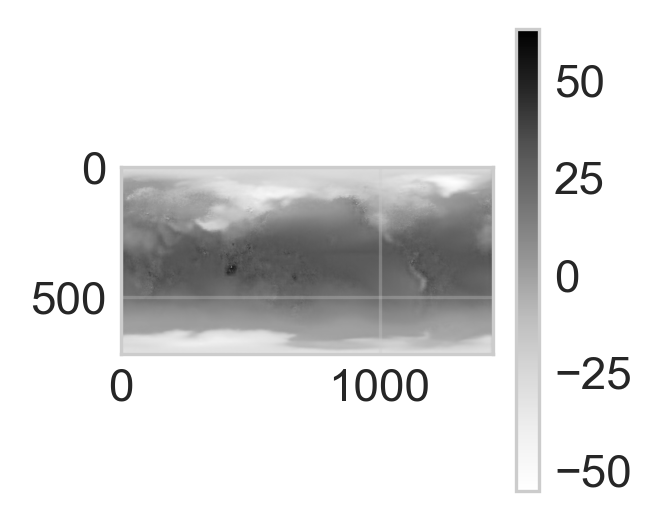

In [9]:
import matplotlib.pyplot as plt
plt.imshow(grid_forecast_np[0, 3, :, :])
plt.colorbar()
plt.show()

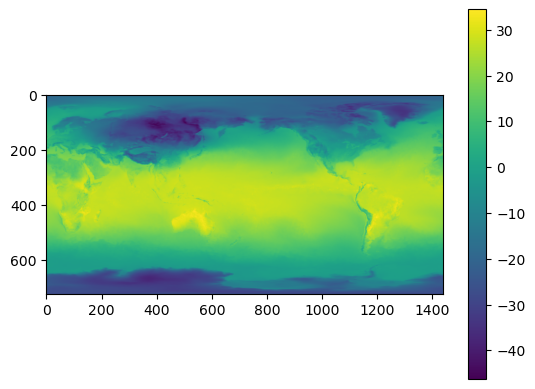

In [6]:
import matplotlib.pyplot as plt
plt.imshow(current_state[0, 3, :, :].cpu().numpy())
plt.colorbar()
plt.show()

In [15]:
input_data.shape

(98, 4, 721, 1440)

In [7]:
def extract_grid_precipitation(grid_data, station_coords):
    """
    Extract precipitation values from grid data at station locations
    grid_data: (1, 4, 721, 1440) - grid data
    station_coords: (12010, 2) - station coordinates
    """
    # Convert to torch tensor
    grid_tensor = torch.FloatTensor(grid_data).to('cuda:1')
    station_coords_tensor = torch.FloatTensor(station_coords).to('cuda:1')
    
    # Normalize coordinates
    lon = station_coords_tensor[..., 0]
    lat = station_coords_tensor[..., 1]
    
    # Normalize longitude to [-1, 1] range
    lon_norm = 2 * torch.where(lon < 0, lon + 360, lon) / 360.0 - 1
    
    # Normalize latitude to [-1, 1] range
    lat_norm = -lat / 90.0
    
    # Stack coordinates with matching dimensions
    normalized_coords = torch.stack([lon_norm, lat_norm], dim=-1).unsqueeze(0)
    
    # Extract values using grid_sample
    station_values = torch.nn.functional.grid_sample(
        grid_tensor,
        normalized_coords.unsqueeze(2),
        mode='bilinear',
        padding_mode='border',
        align_corners=False
    ).squeeze(-1).transpose(1, 2)
    
    return station_values.cpu().numpy()

# Extract original grid precipitation
station_origin_np = extract_grid_precipitation(input_data[-1:], station_coords)
station_from_grid_output = extract_grid_precipitation(grid_forecast_np, station_coords)
station_from_station_output = station_forecast_np


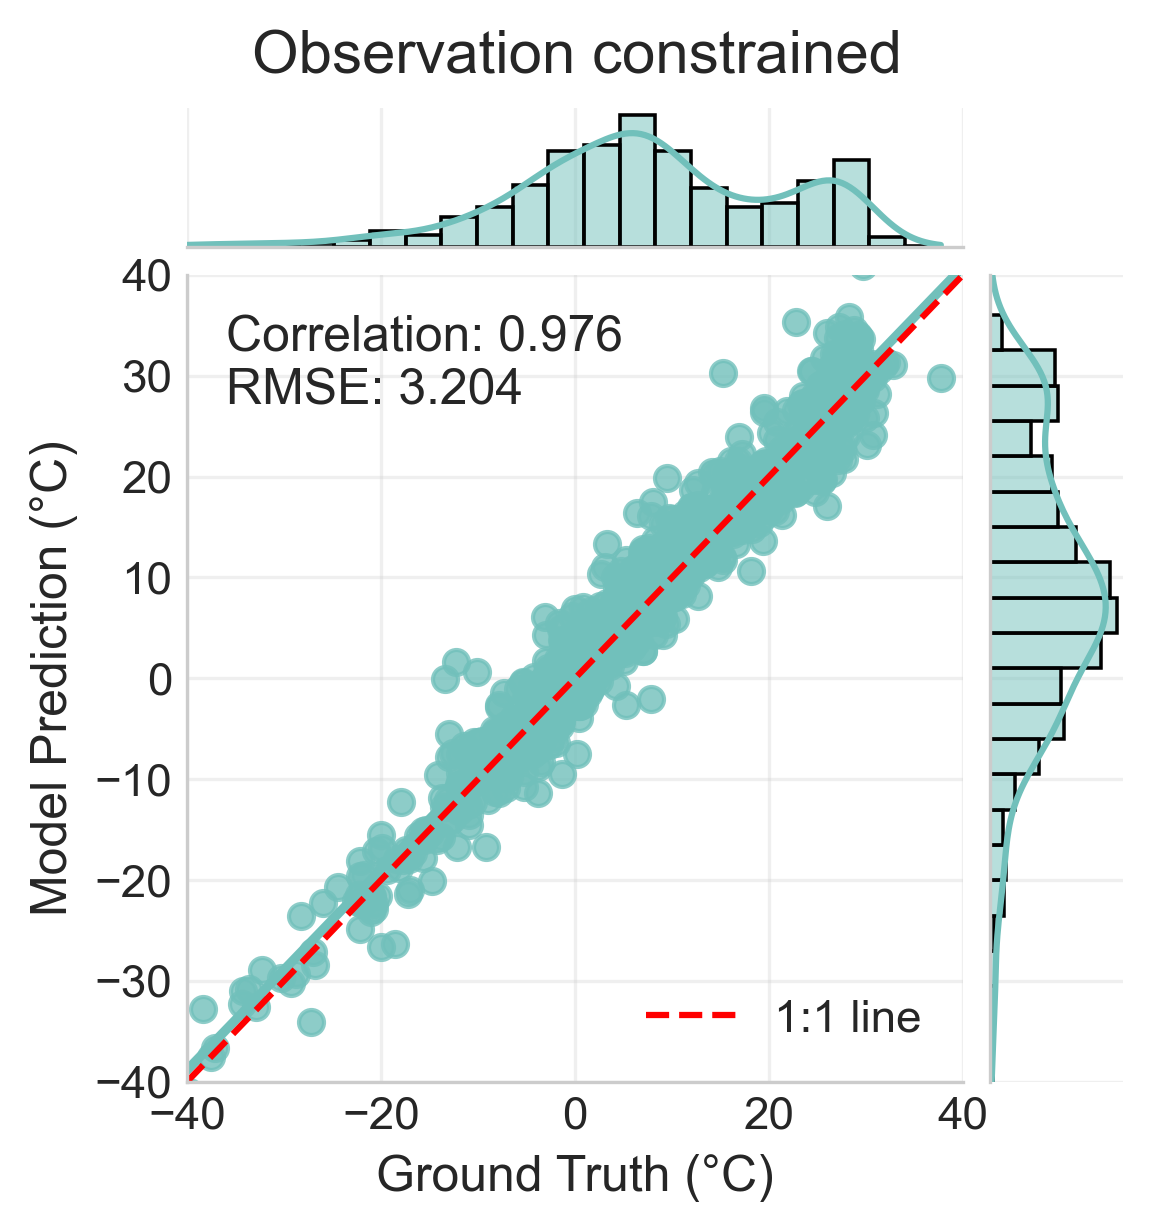

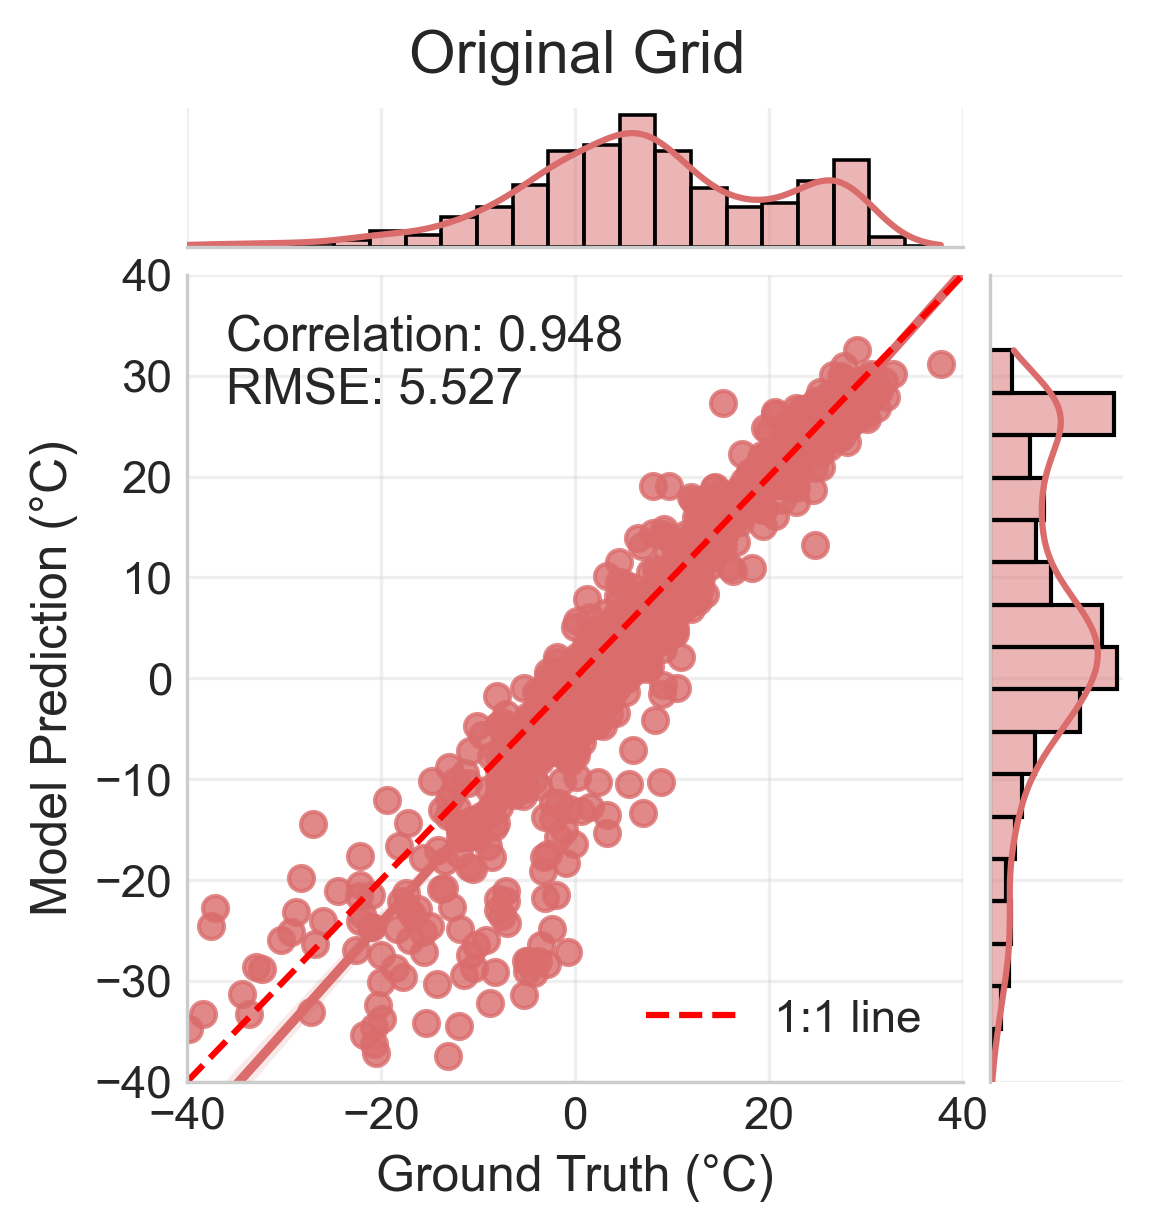


=== Statistics ===
Optimized Model:
Correlation: 0.976
RMSE: 3.204

Original Grid:
Correlation: 0.948
RMSE: 5.527


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd


# 设置全局字体为 Arial
from matplotlib import font_manager
import os

font_path = "/usr/share/fonts/arial/ARIAL.TTF"
font_manager.fontManager.addfont(font_path)
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
## 这里直接贴代码
# 1. 设置Nature风格绘图参数
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.dpi': 300,
    'figure.figsize': (2, 2),
    'grid.alpha': 0.3,
    'lines.linewidth': 1.5,
    'axes.linewidth': 0.8,
    'savefig.bbox': 'tight',
    'savefig.transparent': True
})

colors = ['#71C0BB', '#DA6C6C']

# Randomly select 1000 valid points
index = 3

# Set plot ranges and labels based on index
if index == 0:  # precipitation
    xlim_range = (0, 500)
    ylim_range = (0, 500)
    xlabel = 'Ground Truth (mm/day)'
    ylabel = 'Model Prediction (mm/day)'
elif index == 3:  # temperature
    xlim_range = (-40, 40)
    ylim_range = (-40, 40)
    xlabel = 'Ground Truth (°C)'
    ylabel = 'Model Prediction (°C)'
else:
    # Default ranges for other indices
    xlim_range = (-30, 30)
    ylim_range = (-30, 30)
    xlabel = 'Ground Truth'
    ylabel = 'Model Prediction'

valid_indices = np.where(~np.isnan(station_targets_np[0, :, index]))[0]  # Get indices of non-NaN values
selected_indices = np.random.choice(valid_indices, size=1000, replace=False)

# Extract data for selected points
true_precip = station_targets_np[0, selected_indices, index]  # True precipitation
forecast_precip = station_from_grid_output[0, selected_indices, index]  # Optimized model precipitation
origin_precip = station_origin_np[0, selected_indices, index]  # Original grid precipitation

# Create DataFrame for seaborn
data_optimized = pd.DataFrame({
    'true_precip': true_precip,
    'forecast_precip': forecast_precip
})

data_original = pd.DataFrame({
    'true_precip': true_precip,
    'origin_precip': origin_precip
})

# Create jointplot for optimized model
g1 = sns.jointplot(x="true_precip", y="forecast_precip", data=data_optimized,
                   kind="reg", truncate=False,
                   xlim=xlim_range, ylim=ylim_range,
                   color=colors[0], height=4)
g1.ax_joint.plot([xlim_range[0], xlim_range[1]], [ylim_range[0], ylim_range[1]], 'r--', label='1:1 line')
g1.ax_joint.set_xlabel(xlabel)
g1.ax_joint.set_ylabel(ylabel)
g1.fig.suptitle('Observation constrained', y=1.02)
g1.ax_joint.legend()

# Calculate correlation and RMSE for optimized model
corr_a = np.corrcoef(true_precip, forecast_precip)[0,1]
rmse_a = np.sqrt(np.mean((true_precip - forecast_precip)**2))
g1.ax_joint.text(0.05, 0.95, f'Correlation: {corr_a:.3f}\nRMSE: {rmse_a:.3f}', 
                 transform=g1.ax_joint.transAxes, verticalalignment='top')

plt.show()

# Create jointplot for original grid
g2 = sns.jointplot(x="true_precip", y="origin_precip", data=data_original,
                   kind="reg", truncate=False,
                   xlim=xlim_range, ylim=ylim_range,
                   color=colors[1], height=4)
g2.ax_joint.plot([xlim_range[0], xlim_range[1]], [ylim_range[0], ylim_range[1]], 'r--', label='1:1 line')
g2.ax_joint.set_xlabel(xlabel)
g2.ax_joint.set_ylabel(ylabel)
g2.fig.suptitle('Original Grid', y=1.02)
g2.ax_joint.legend()

# Calculate correlation and RMSE for original grid
corr_b = np.corrcoef(true_precip, origin_precip)[0,1]
rmse_b = np.sqrt(np.mean((true_precip - origin_precip)**2))
g2.ax_joint.text(0.05, 0.95, f'Correlation: {corr_b:.3f}\nRMSE: {rmse_b:.3f}', 
                 transform=g2.ax_joint.transAxes, verticalalignment='top')

plt.show()

# Print statistics
print("\n=== Statistics ===")
print("Optimized Model:")
print(f"Correlation: {corr_a:.3f}")
print(f"RMSE: {rmse_a:.3f}")
print("\nOriginal Grid:")
print(f"Correlation: {corr_b:.3f}")
print(f"RMSE: {rmse_b:.3f}")

In [24]:
import xarray as xr
import numpy as np

# Open the dataset
temp = xr.open_dataset('/data/lhwang/npy/temp.nc', engine='netcdf4')
t2m_data = current_state[0, 3, :, :].cpu().numpy() #grid_forecast_np[0, 3, :, :] 

# Create DataArray with same coordinates as template
t2m = xr.DataArray(
    t2m_data,
    coords={
        'lat': temp.lat,
        'lon': temp.lon
    },
    dims=['lat', 'lon'],
    name='t2m'
)

In [16]:
t2m.values


array([[ -6.510848 , -12.708402 ,  -8.98651  , ...,  -5.75541  ,
         -9.305333 ,  -1.7699492],
       [-14.203574 , -18.953884 , -22.472435 , ..., -16.413876 ,
        -14.499164 ,  -8.33209  ],
       [-10.211103 , -18.053997 , -19.921331 , ..., -15.906837 ,
        -14.4093075,  -6.7708964],
       ...,
       [-11.626169 , -23.806267 , -23.038015 , ..., -14.9372425,
        -13.476369 ,  -5.7642264],
       [-18.849157 , -26.165224 , -28.397738 , ..., -16.853762 ,
        -15.1833   ,  -8.874196 ],
       [-10.63524  , -23.94589  , -20.62934  , ..., -12.390862 ,
        -12.155896 ,  -5.77234  ]], dtype=float32)

/home/lhwang/Desktop/e2e_constrain/code/utils/plot.py:788: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


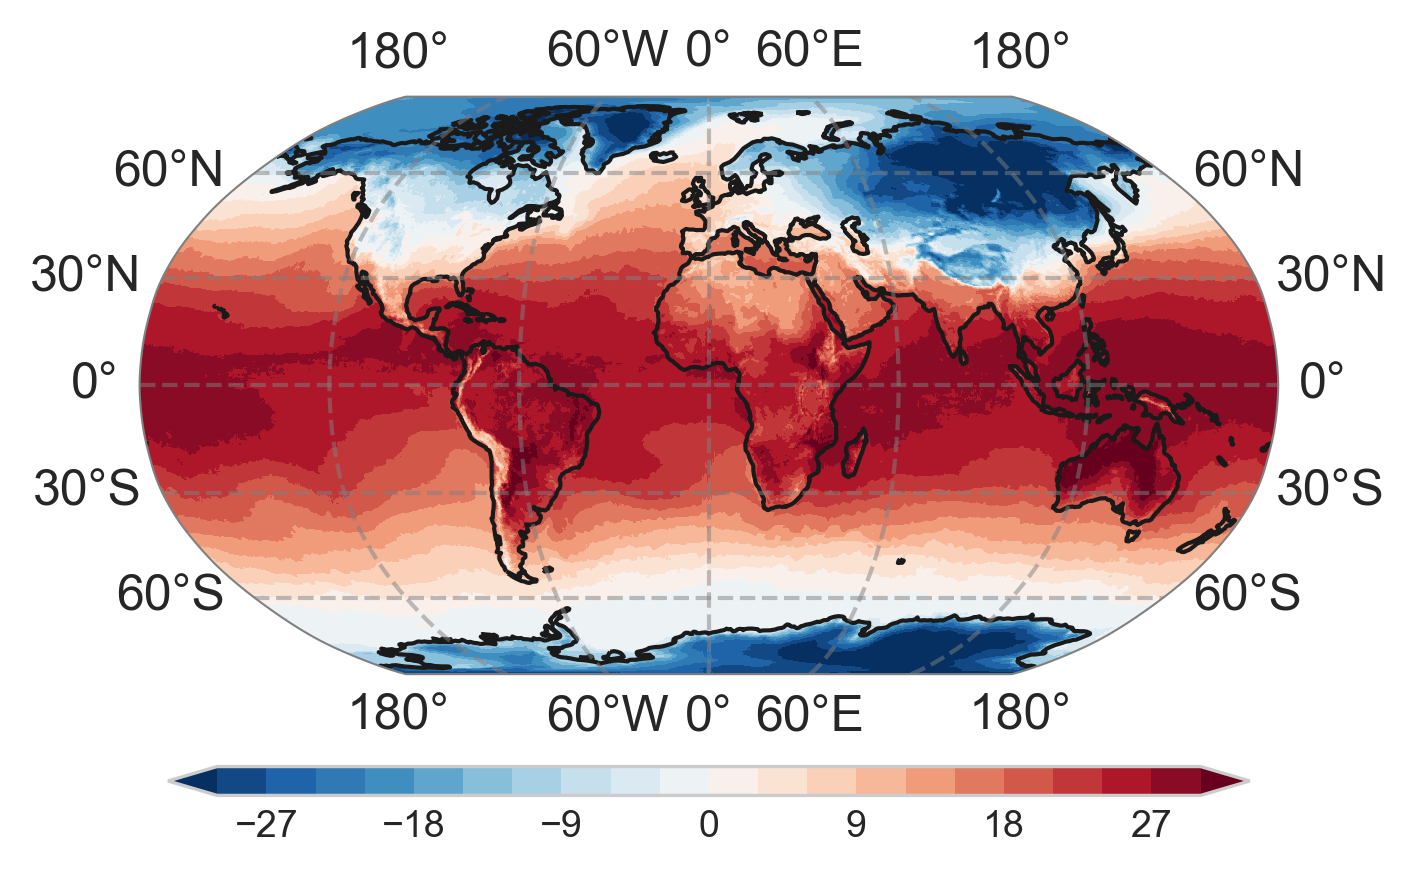

In [25]:
import xarray as xr
from utils import plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
fig = plt.figure(figsize=(5, 2.5))
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-30, 30, num=21)
plot.one_map_global_line(t2m, ax, levels=levels, cmap="RdBu_r",  mask_ocean=False, add_coastlines=True, add_land=True,  colorbar=True, plotfunc="pcolormesh")

/home/lhwang/Desktop/e2e_constrain/code/utils/plot.py:788: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


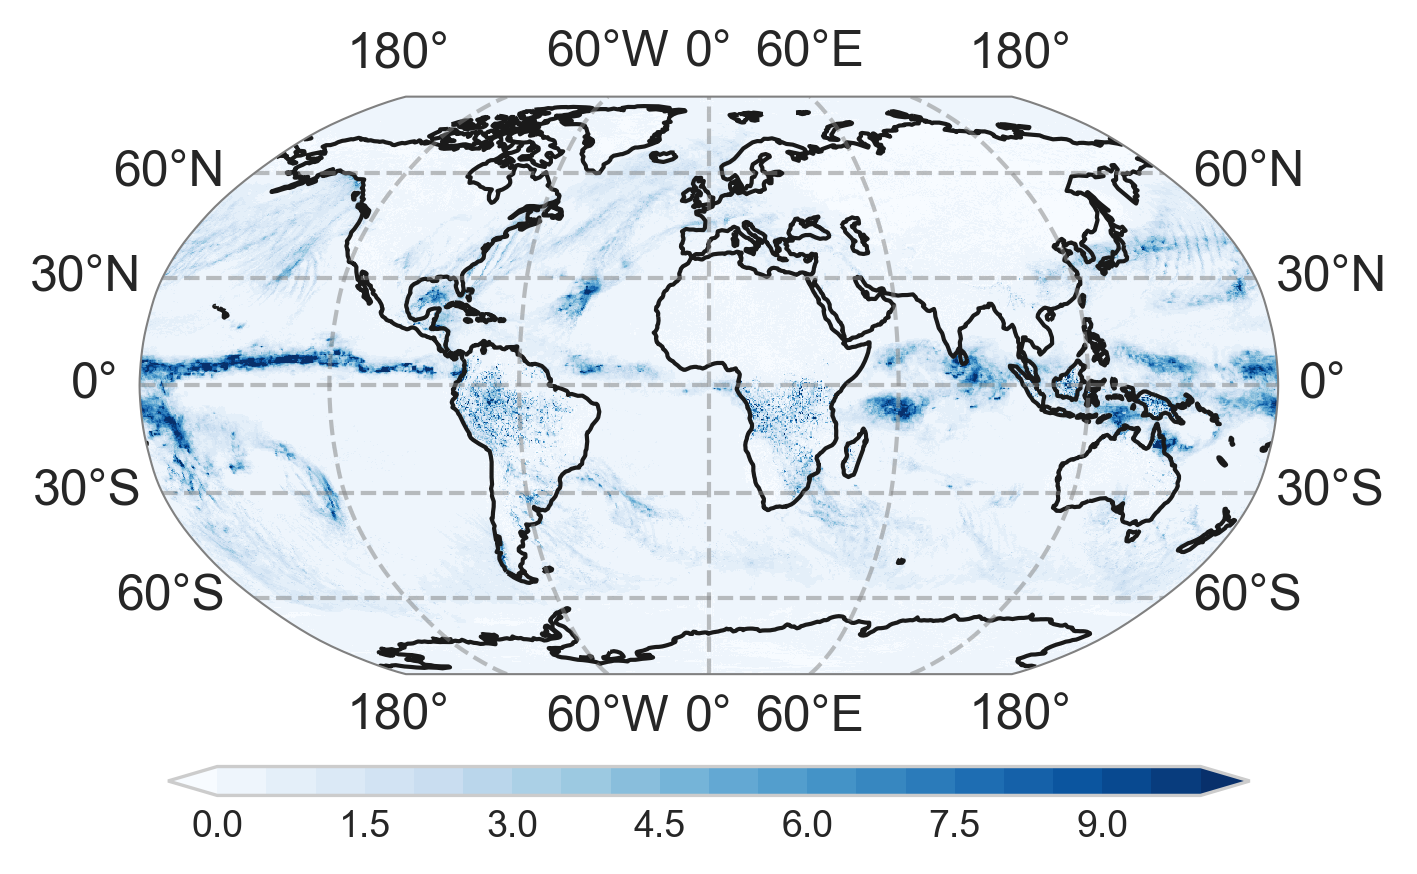

In [27]:
t2m_data = current_state[0, 0, :, :].cpu().numpy() #grid_forecast_np[0, 3, :, :] 

# Create DataArray with same coordinates as template
t2m = xr.DataArray(
    t2m_data,
    coords={
        'lat': temp.lat,
        'lon': temp.lon
    },
    dims=['lat', 'lon'],
    name='tp'
)

fig = plt.figure(figsize=(5, 2.5))
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 10, num=21)
plot.one_map_global_line(t2m, ax, levels=levels, cmap="Blues",  mask_ocean=False, add_coastlines=True, add_land=True,  colorbar=True, plotfunc="pcolormesh")

/home/lhwang/Desktop/e2e_constrain/code/utils/plot.py:788: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


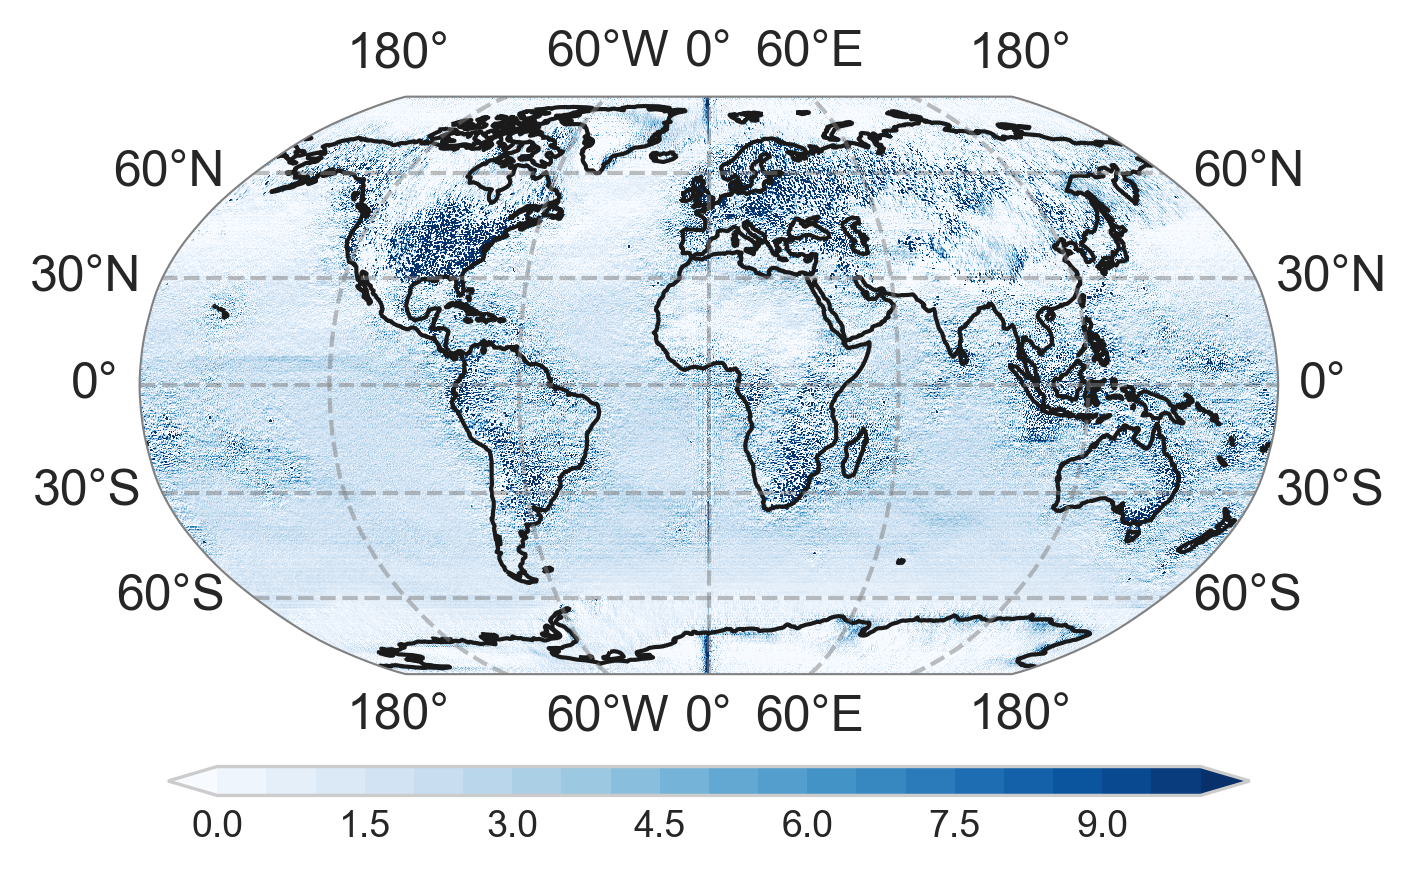

In [28]:
t2m_data = grid_forecast_np[0, 0, :, :] 

# Create DataArray with same coordinates as template
t2m = xr.DataArray(
    t2m_data,
    coords={
        'lat': temp.lat,
        'lon': temp.lon
    },
    dims=['lat', 'lon'],
    name='tp'
)

fig = plt.figure(figsize=(5, 2.5))
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 10, num=21)
plot.one_map_global_line(t2m, ax, levels=levels, cmap="Blues",  mask_ocean=False, add_coastlines=True, add_land=True,  colorbar=True, plotfunc="pcolormesh")